## [Practice 3] Face_Recognition
* 0. 실습 환경 설정
* 1. 데이터 준비하기
    * 1-1. 모듈불러오기
    * 1-2. 데이터 전처리하기
    * 1-3. Customdata .lst .rec .idx 생성
* 2. Training
* 3. Testing
* 4. Inference
    * 3-1. 얼굴인식 전처리 상수 및 함수 선언
    * 3-2. 모델 불러오기 및 얼굴 인식
        * KFACE
        * MS1MV3 Weights


### 0. 실습 환경 설정
### 0-0. 데이터 전처리 환경 설정
* 가상환경명 : fr77
* Python 버전 : python 3.7
* 설치 목록
    * !pip install tqdm
    * !pip install PyYAML
    * !pip install scipy
    * !pip install mxnet
    * !pip install opencv-python
### 0-1. 학습 환경 설정
* 가상환경명 : fr
* Python 버전 : python 3.8
* 설치 목록
    * !pip install torch==1.7.1+cu110 torchvision==0.8.2+cu110 -f https://download.pytorch.org/whl/torch_stable.html
    * opencv_python==4.1.0.25
    * matplotlib
    * python-time
    * torchsummary
    * Dlib 설치
        * !git clone https://github.com/sachadee/Dlib.git
        * python -m pip install dlib-19.22.99-cp38-cp38m-win_amd64.whl
* Arcface Git 주소 : https://github.com/deepinsight/insightface

In [ ]:
# Colab
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
# !git clone https://github.com/deepinsight/insightface.git

### 1. 데이터 준비하기

* 가상환경 : fr77
* window에서 mxnet, python3.7사용해야 오류안남
    * SyntaxError: 'yield' inside list comprehension

### 1-1. 모듈 불러오기

In [ ]:
import numpy as np
import zipfile
import os
import shutil
import cv2
from PIL import Image
from tqdm import tqdm
from glob import glob
import re
import os
import time
import dlib
import cv2
import yaml
import numpy as np
from scipy.spatial import distance

### 1-2. 데이터 전처리하기

* TODO : AI-HUB 한국인 안면 이미지 신청하기 [링크](https://www.aihub.or.kr/aihubdata/data/view.do?currMenu=&topMenu=&aihubDataSe=realm&dataSetSn=83)
* TODO : `Middle_Resolution.zip` 다운로드
* TODO : 경로 변경 필요 (`Middle_Resolution.zip` 위치)

In [ ]:
cd 경로변경

In [ ]:
if not os.path.exists("kface_data/"):
    os.makedirs("kface_data/")

In [ ]:
# unzip
if not os.path.exists("Middle_Resolution"): os.makedirs("Middle_Resolution")
zipfile.ZipFile("Middle_Resolution.zip").extractall("Middle_Resolution")

In [ ]:
# 하위 폴더 unzip
current_folder = './'
root_folder = './Middle_Resolution'
file_list = os.listdir(root_folder)
print("class의 개수 : ", len(file_list))

class_names = []
for file in file_list:
    class_names.append(file.split('.')[0])

print("class이름 예시 : ", class_names[:5])

class의 개수 :  400
class이름 예시 :  ['19062421', '19062431', '19062521', '19062531', '19062542']


In [ ]:
# 다양한 데이터셋 중 사용할 Status
lux = ["L1", "L3"]
emotion = ["E01", "E02", "E03"]
angle = ["C6", "C7", "C8", "C9"]
accs = ['S001']
img_names = []
txt_names = []
for acc in accs:
    for l in lux:
        for e in emotion:
            for c in angle:
                img_names.append(acc + '/' + l + '/' + e + '/' + c + '.jpg')
                txt_names.append(acc + '/' + l + '/' + e + '/' + c + '.txt')

for file, cls_ in tqdm(zip(file_list, class_names)):
    if not os.path.exists("kface_data/" + cls_):
        os.makedirs("kface_data/" + cls_)

    for img, txt in zip(img_names, txt_names):
        zipfile.ZipFile(os.path.join(root_folder, file)).extract(img)
        zipfile.ZipFile(os.path.join(root_folder, file)).extract(txt)
    shutil.move("S001", "kface_data/" + cls_)

400it [34:29,  5.17s/it]


In [ ]:
# crop
if not os.path.exists("fr_kface"):
    os.makedirs("fr_kface")
if not os.path.exists("fr_kface/train"):
    os.makedirs("fr_kface/train")
if not os.path.exists("fr_kface/val"):
    os.makedirs("fr_kface/val")

fi = open('./file_list.txt', 'w')

for j, c in enumerate(class_names):
    imgs = glob("kface_data/" + c + "/*/*/*/*.jpg")
    txts = glob("kface_data/" + c + "/*/*/*/*.txt")

    for i, (img, txt) in enumerate(zip(imgs, txts)):
        name = str(i)
        
        with open(txt, 'r') as f:
            bbox = f.read().split('\n')[7].split()
            bbox = list(map(int, bbox))
            (x, y, w, h) = bbox

            img = cv2.imread(img)
            img = img[y: y + h, x: x + w]
            img = cv2.resize(img, (112,112))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            if j >= 390:
                base_val = "fr_kface/val/" + str(j - 390)
                if not os.path.exists(base_val):
                    os.makedirs(base_val)
                paaa = os.path.join(base_val, str(j-390) + '_' + name)+ '.jpg'
                Image.fromarray(img).save(os.path.join(base_val, str(j-390) + '_' + name) + '.jpg')
            else:
                base = "fr_kface/train/" + str(j)

                if not os.path.exists(base):
                    os.makedirs(base)
                paaa = os.path.join(base, str(j) + '_' + name)+ '.jpg'
                Image.fromarray(img).save(os.path.join(base, str(j) + '_' + name) + '.jpg')
        t_ = f"{paaa} {j}\n"
        fi.write(t_)
fi.close()

### 1-3. Customdata .lst .rec .idx 생성

In [ ]:
!python -m mxnet.tools.im2rec ./train fr_kface/train --list --recursive

In [ ]:
!python -m mxnet.tools.im2rec ./  fr_kface/train --recursive --pass-through --pack-label --num-thread 8

In [ ]:
!python -m mxnet.tools.im2rec ./val fr_kface/val --list --recursive

In [ ]:
!python -m mxnet.tools.im2rec ./  fr_kface/val --recursive --pass-through --pack-label --num-thread 4

### 2. Training

#### Config 파일 만들기

* TODO : insightface/recognition/arcface_torch/configs/kface_r50_onegpu.py로 생성
* TODO : 경로 변경 (insightface/recognition/arcface_torch로)

In [ ]:
cd

In [ ]:
'''
from easydict import EasyDict as edict

# make training faster
# our RAM is 256G
# mount -t tmpfs -o size=140G  tmpfs /train_tmp

config = edict()
config.margin_list = (1.0, 0.5, 0.0)
config.network = "r50"
config.resume = False
config.output = None
config.embedding_size = 512
config.sample_rate = 1.0
config.fp16 = True
config.momentum = 0.9
config.weight_decay = 5e-4
config.batch_size = 16
config.lr = 0.001
config.verbose = 2000
config.dali = False

config.rec = "/content/drive/MyDrive/dataset/face_recognition/kface"
config.num_classes = 390
config.num_image = 9360
config.num_epoch = 50
config.warmup_epoch = 0
config.val_targets = ['lfw', 'cfp_fp', "agedb_30"]

'''

In [ ]:
!python train_v2.py configs/kface_r50_onegpu

### 3. Inference

* TODO : 경로 변경 (insightface/recognition/arcface_torch로)

In [ ]:
cd 

### 3-1. 얼굴인식 전처리 상수 및 함수 선언

In [ ]:
import numpy as np
import dlib 
import cv2
import matplotlib.pyplot as plt
import time
import os
from collections import OrderedDict

import torch 
from torch import nn
from torch.utils.checkpoint import checkpoint
from torchsummary import summary

from backbones.iresnet import iresnet50

In [4]:
FACIAL_LANDMARKS_68_IDXS = OrderedDict([
	("mouth", (48, 68)),
	("inner_mouth", (60, 68)),
	("right_eyebrow", (17, 22)),
	("left_eyebrow", (22, 27)),
	("right_eye", (36, 42)),
	("left_eye", (42, 48)),
	("nose", (27, 36)),
	("jaw", (0, 17))
])

FACIAL_LANDMARKS_5_IDXS = OrderedDict([
	("right_eye", (2, 3)),
	("left_eye", (0, 1)),
	("nose", (4))
])

FACIAL_LANDMARKS_IDXS = FACIAL_LANDMARKS_68_IDXS

def rect_to_bb(rect):
	x = rect.left()
	y = rect.top()
	w = rect.right() - x
	h = rect.bottom() - y
	return (x, y, w, h)

def shape_to_np(shape, dtype="int"):
	coords = np.zeros((shape.num_parts, 2), dtype=dtype)

	for i in range(0, shape.num_parts):
		coords[i] = (shape.part(i).x, shape.part(i).y)

	return coords

In [5]:
class FaceAligner:
    def __init__(self, predictor, desiredLeftEye=(0.35, 0.35),
        desiredFaceWidth=256, desiredFaceHeight=None):

        self.predictor = predictor
        self.desiredLeftEye = desiredLeftEye
        self.desiredFaceWidth = desiredFaceWidth
        self.desiredFaceHeight = desiredFaceHeight


        if self.desiredFaceHeight is None:
            self.desiredFaceHeight = self.desiredFaceWidth

    def align(self, image, gray, rect):
        shape = self.predictor(gray, rect)
        shape = shape_to_np(shape)

        if (len(shape)==68):
            (lStart, lEnd) = FACIAL_LANDMARKS_68_IDXS["left_eye"]
            (rStart, rEnd) = FACIAL_LANDMARKS_68_IDXS["right_eye"]
        else:
            (lStart, lEnd) = FACIAL_LANDMARKS_5_IDXS["left_eye"]
            (rStart, rEnd) = FACIAL_LANDMARKS_5_IDXS["right_eye"]
            
        leftEyePts = shape[lStart:lEnd]
        rightEyePts = shape[rStart:rEnd]

        # compute the center of mass for each eye
        leftEyeCenter = leftEyePts.mean(axis=0).astype("int")
        rightEyeCenter = rightEyePts.mean(axis=0).astype("int")

        # compute the angle between the eye centroids
        dY = rightEyeCenter[1] - leftEyeCenter[1]
        dX = rightEyeCenter[0] - leftEyeCenter[0]
        angle = np.degrees(np.arctan2(dY, dX)) - 180

        desiredRightEyeX = 1.0 - self.desiredLeftEye[0]

        dist = np.sqrt((dX ** 2) + (dY ** 2))
        desiredDist = (desiredRightEyeX - self.desiredLeftEye[0])
        desiredDist *= self.desiredFaceWidth
        scale = desiredDist / dist

        eyesCenter = (int((leftEyeCenter[0] + rightEyeCenter[0]) // 2),
            int((leftEyeCenter[1] + rightEyeCenter[1]) // 2))

        # grab the rotation matrix for rotating and scaling the face
        M = cv2.getRotationMatrix2D(eyesCenter, angle, scale)

        # update the translation component of the matrix
        tX = self.desiredFaceWidth * 0.5
        tY = self.desiredFaceHeight * self.desiredLeftEye[1]
        M[0, 2] += (tX - eyesCenter[0])
        M[1, 2] += (tY - eyesCenter[1])

        # apply the affine transformation
        (w, h) = (self.desiredFaceWidth, self.desiredFaceHeight)
        output = cv2.warpAffine(image, M, (w, h),
            flags=cv2.INTER_CUBIC)

        return output

* TODO : DLIB - face_landmark_detection 모델 다운로드 [링크](http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2)
* TODO : 압축풀기
* TODO : `predictor_file`에 `shape_predictor_68_face_landmarks.dat` 경로 넣어주기

In [ ]:
predictor_file = 
face_detector = dlib.get_frontal_face_detector()
shape_predictor = dlib.shape_predictor(predictor_file)
fa = FaceAligner(shape_predictor, desiredFaceWidth=112)

In [ ]:
def l2_norm(x, axis=1):
    norm = np.linalg.norm(x, axis=axis, keepdims=True)
    return x / norm

In [6]:
def face_embedding(model, img, dsize=112, device='cuda'):
    img = cv2.resize(img, (dsize,dsize))
    img = np.transpose(img, (2, 0, 1))
    img = torch.from_numpy(img).unsqueeze(0).float()
    img.div_(255).sub_(0.5).div_(0.5)
    img = img.to(device)
    embed = model(img).detach().cpu().numpy()
    return l2_norm(embed)

### 3-2. 모델 불러오기 및 얼굴 인식
* KFACE Fine tuning

* TODO : `weight_path`에 `face_recoognition.pt` or 학습한 가중치 경로 넣어주기

In [8]:
weight_path = 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = iresnet50().to(device)
model.load_state_dict(torch.load(weight_path, map_location = device))
model.eval()
print("Model Loaded!")
# summary(model, (3, 112, 112))

Model Loaded!


* TODO : 폴더 만들어서 연예인 얼굴 사진 넣어주기
* TODO : 해당경로 `folder_path`에 넣어주기

In [9]:
folder_path = 
person_list = os.listdir(folder_path)

known_face_embeddings = []
known_face_names = []

for p in person_list:
    name, _ = os.path.splitext(p)
    known_face_names.append(name)
    person_img = cv2.imread(os.path.join(folder_path, p))
    person_img_gray = cv2.cvtColor(person_img, cv2.COLOR_BGR2GRAY)
    face_detection = face_detector(person_img, 2)
    f = face_detection[0]
    faceAligned = fa.align(person_img, person_img_gray, f)
    known_embed = face_embedding(model, faceAligned, 112)
    known_face_embeddings.append(known_embed)


* TODO : 그룹가수 사진 다운로드
* TODO : 해당경로 `test_img_path`에 넣어주기

KimYongjun [1.1609862]
LeeSeokHoon [1.1729288]
KimJinHo [0.9238889]


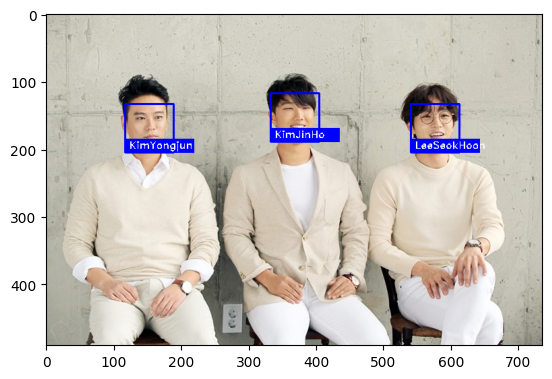

In [11]:
test_img_path = 
test_img = cv2.imread(test_img_path)
test_img_gray = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)
face_detection = face_detector(test_img)
for f in face_detection:
    faceAligned = fa.align(test_img, person_img_gray, f)
    camera_embed = face_embedding(model, faceAligned, 112)

    distances = []
    for idx, embd in enumerate(known_face_embeddings):
        embeds_distance = np.subtract(camera_embed, embd)
        embeds_distance = np.sum(np.square(embeds_distance), axis=1)
        distances.append(embeds_distance)
    name = 'unknown'
    if min(distances) < 1.5:
        idx = np.argmin(distances)
        name = known_face_names[idx]
        print(name, min(distances))
    cv2.rectangle(test_img, (f.left(), f.top()), (f.right(), f.bottom()), (255,0,0), 2) 
    cv2.rectangle(test_img, (f.left(), f.bottom()-20), (f.right()+30, f.bottom()), (255,0,0), cv2.FILLED)
    font = cv2.FONT_HERSHEY_DUPLEX
    cv2.putText(test_img, name, (f.left()+6,f.bottom()-6), font, 0.5, (255,255,255), 1)   
cv2.imwrite("result.png", test_img)
plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
plt.show()


* MS1MV3 Weights

* TODO : ms1mv3_arcface_r50_fp16 pre-trained 파일 다운로드 [링크](https://onedrive.live.com/?authkey=%21AFZjr283nwZHqbA&id=4A83B6B633B029CC%215577&cid=4A83B6B633B029CC)
* TODO : weight_path에 `ms1mv3_arcface_r50_fp16/backbone.pth` 경로 넣어주기

In [120]:
weight_path = 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = iresnet50().to(device)
model.load_state_dict(torch.load(weight_path, map_location = device))
model.eval()
print("Model Loaded!")
# summary(model, (3, 112, 112))

Model Loaded!


* TODO : 폴더 만들어서 연예인 얼굴 사진 넣어주기
* TODO : 해당경로 `folder_path`에 넣어주기

In [69]:
folder_path = 
person_list = os.listdir(folder_path)

known_face_embeddings = []
known_face_names = []

for p in person_list:
    name, _ = os.path.splitext(p)
    known_face_names.append(name)
    person_img = cv2.imread(os.path.join(folder_path, p))
    person_img_gray = cv2.cvtColor(person_img, cv2.COLOR_BGR2GRAY)
    face_detection = face_detector(person_img, 2)
    f = face_detection[0]
    faceAligned = fa.align(person_img, person_img_gray, f)
    known_embed = face_embedding(model, faceAligned, 112)
    known_face_embeddings.append(known_embed)

* TODO : 그룹가수 사진 다운로드
* TODO : 해당경로 `test_img_path`에 넣어주기

KimYongjun [1.2629459]
LeeSeokHoon_ [1.2748593]
KimJinHo [1.123605]


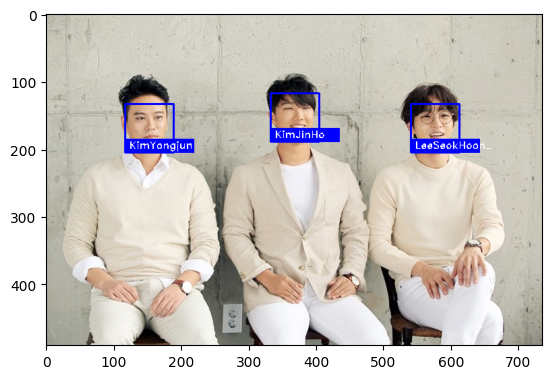

In [70]:
test_img_path = 
test_img = cv2.imread(test_img_path)
test_img_gray = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)
face_detection = face_detector(test_img)
for f in face_detection:
    faceAligned = fa.align(test_img, person_img_gray, f)
    camera_embed = face_embedding(model, faceAligned, 112)

    distances = []
    for idx, embd in enumerate(known_face_embeddings):
        embeds_distance = np.subtract(camera_embed, embd)
        embeds_distance = np.sum(np.square(embeds_distance), axis=1)
        distances.append(embeds_distance)
    name = 'unknown'
    if min(distances) < 1.5:
        idx = np.argmin(distances)
        name = known_face_names[idx]
        print(name, min(distances))
    cv2.rectangle(test_img, (f.left(), f.top()), (f.right(), f.bottom()), (255,0,0), 2) 
    cv2.rectangle(test_img, (f.left(), f.bottom()-20), (f.right()+30, f.bottom()), (255,0,0), cv2.FILLED)
    font = cv2.FONT_HERSHEY_DUPLEX
    cv2.putText(test_img, name, (f.left()+6,f.bottom()-6), font, 0.5, (255,255,255), 1)   
cv2.imwrite("result.png", test_img)
plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
plt.show()
